# Replication of De Bondt and Thaler (1985)

This notebook is created by LYYU0413. The original notebook is adapted from code written by [Charles Martineau](http://www.charlesmartineau.com/) at the University of Toronto and readjusted from notebook prepared by [Vincent Grégoire](http://www.vincentgregoire.com).

Objectives:

- Test for the overreaction hypothesis in financial markets based on 
  [De Bondt and Thaler (1985), Does the Stock Market Overreact?,
  Journal of Finance](http://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1985.tb05004.x/full).
- Get similar results to Figure 3 in the paper.

Motivation and Hypothesis:

- Research in experimental psychology has suggested that, in violation of
  Baye's rule, most people "overreact" to unexpected and dramatic news
  events. The question then arises whether such behavior matters at the
  market level.
  
Compared with the original notebook, I changed some cells of codes, chose another different testing dataset and readjusted the data preparasion process. 

In [1]:
# load packages

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import gzip

## Step 1: load the CRSP monthly file

The CRSP (center for research in security prices) monthly file is proprietary data and cannot be shared freely online, we will use a small fraction of the CRSP monthly data to try to repeat the results. 


In [2]:
 # Load part of the file to have a look

with open('../data/CRSP_monthly.csv', 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    df_crsp = pd.read_csv(gzip_fd)

In [4]:
df_crsp.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,vwretd,ewretd
0,10000,19860131,-4.37500,1771.0,C,3680.0,0.009829,0.044071
1,10000,19860228,-3.25000,828.0,-0.257143,3680.0,0.072500,0.060381
2,10000,19860331,-4.43750,1078.0,0.365385,3680.0,0.053885,0.047192
3,10000,19860430,-4.00000,957.0,-0.098592,3793.0,-0.007903,0.016140
4,10000,19860530,-3.10938,1074.0,-0.222656,3793.0,0.050844,0.036194


exam the data structure of imported CRSP.csv file:
- PERMNO: functioned as index, unique for the company. PERMNO is a unique permanent security identification number assigned by CRSP to each security. PERMNO is currently a 5-digit integer for all common securities in the CRSP files. Unlike CUSIP, Ticker Symbol, and Company Name, a PERMNO does not change during an issue's trading history, nor is it reassigned after an issue ceases trading. This allows users track a security through its entire trading history in CRSP files with a single PERMNO, regardless of name or capital structure changes. It is useful to know Stock data are sorted and indexed by this field.
- date: the data format in yyyymmdd
- PRC: the *closing price* of that month
- VOL: the sum of the trading volume of that specific month.
- RET: [P(t)f(t) + d(t)]/P(t') - 1
- SHROUT: shareoutstanding recorded in thousands. 
- vwretd: (market) value weighted market portfolio
- ewretd: equal weighted market portfolio

As we can observe from exploring the original data, we can replace "C" and "B" with na value.

In [6]:
with open('../data/CRSP_monthly.csv', 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    df_crsp = pd.read_csv(gzip_fd, na_values=['C',"B"], parse_dates=['date'])

# The output from WRDS returns a mixed of small and large cap column names.
# We can easily convert everything to small caps.

cols = df_crsp.columns
df_crsp.columns = [c.lower() for c in cols]

In [7]:
df_crsp.head()

,permno,date,prc,vol,ret,shrout,vwretd,ewretd
0,10000,1986-01-31,-4.37500,1771.0,NaN,3680.0,0.009829,0.044071
1,10000,1986-02-28,-3.25000,828.0,-0.257143,3680.0,0.072500,0.060381
2,10000,1986-03-31,-4.43750,1078.0,0.365385,3680.0,0.053885,0.047192
3,10000,1986-04-30,-4.00000,957.0,-0.098592,3793.0,-0.007903,0.016140
4,10000,1986-05-30,-3.10938,1074.0,-0.222656,3793.0,0.050844,0.036194


In [8]:
df_crsp.tail()

,permno,date,prc,vol,ret,shrout,vwretd,ewretd
2962990,93436,2018-08-31,301.66000,2773316.0,0.011806,170593.0,0.030221,0.019158
2962991,93436,2018-09-28,264.76999,1960767.0,-0.122290,171578.0,0.000443,-0.010314
2962992,93436,2018-10-31,337.32001,2864231.0,0.274011,171733.0,-0.074031,-0.082433
2962993,93436,2018-11-30,350.48001,1331285.0,0.039013,171733.0,0.018530,0.000576
2962994,93436,2018-12-31,332.79999,1464466.0,-0.050445,171733.0,-0.089810,-0.099310


In [9]:
df_crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962995 entries, 0 to 2962994
Data columns (total 8 columns):
permno    int64
date      datetime64[ns]
prc       float64
vol       float64
ret       float64
shrout    float64
vwretd    float64
ewretd    float64
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 180.8 MB


In [10]:
df_crsp.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd
count,2.962995e+06,2.880570e+06,2.899221e+06,2.858911e+06,2.940144e+06,2.962995e+06,2.962995e+06
mean,6.312662e+04,3.162961e+01,1.068272e+05,9.411686e-03,5.911980e+04,8.876376e-03,9.467395e-03
std,2.853605e+04,1.385703e+03,7.574144e+05,1.776623e-01,2.676477e+05,4.384836e-02,5.192372e-02
min,1.000000e+04,-1.500000e+03,0.000000e+00,-9.936000e-01,0.000000e+00,-2.253630e-01,-2.722480e-01
25%,3.958900e+04,4.150000e+00,1.759000e+03,-5.882400e-02,5.107000e+03,-1.694800e-02,-1.854900e-02
50%,7.704300e+04,1.293750e+01,8.898000e+03,7.280000e-04,1.368900e+04,1.372900e-02,1.419900e-02
75%,8.547200e+04,2.617000e+01,4.547900e+04,6.171400e-02,3.929600e+04,3.817500e-02,3.782700e-02
max,9.343600e+04,3.260000e+05,2.012427e+08,2.400000e+01,2.920640e+07,1.284960e-01,2.250380e-01


In [11]:
# Set the index (to select easily on date)
df_crsp = df_crsp.set_index('date')
df_crsp = df_crsp.sort_index()

In [12]:
# Some data cleaning

# Drop obs with missing returns
df_crsp = df_crsp[df_crsp.ret.notnull()]

df_crsp['prc'] = np.abs(df_crsp['prc'])

In [13]:
# Compute continuously compounded returns (i.e. log returns).
# Why are these useful?
# because we want make sure the result does not influced by the conputing power for float
# https://www.johndcook.com/blog/2012/07/25/trick-for-computing-log1x/
df_crsp['lret'] = np.log(1 + df_crsp['ret'])
df_crsp['lvwretd'] = np.log(1 + df_crsp['vwretd'])
df_crsp['lewretd'] = np.log(1 + df_crsp['ewretd'])

# Compute the market cap (market capitalization)
df_crsp['size'] = df_crsp['shrout'] * df_crsp['prc']

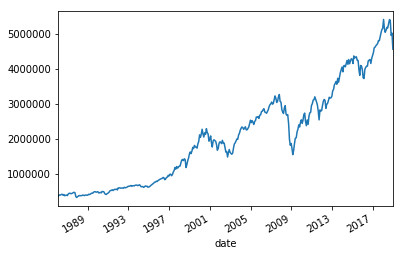

In [14]:
# Look at the average size over time
# average market capitalization
df_crsp.groupby(['date'])['size'].mean().plot()

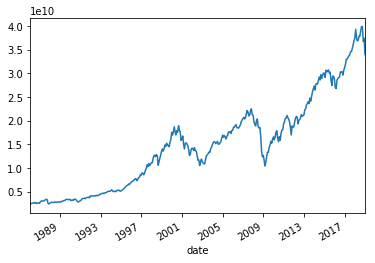

In [15]:
# Total market size over time

ax = df_crsp.groupby(['date'])['size'].sum().plot()

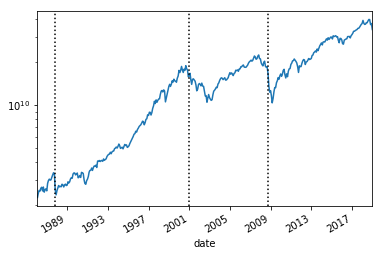

In [16]:
# More informative in logs!
ax = df_crsp.groupby(['date'])['size'].sum().plot(logy=True)

# Add some informative lines
ax.axvline(x=datetime(1929,10,24), color='k', linestyle=':') # Big news for America happened 
ax.axvline(x=datetime(1987,10,19), color='k', linestyle=':')
ax.axvline(x=datetime(2001,1,1), color='k', linestyle=':') # Big news for America happened 
ax.axvline(x=datetime(2008,9,16), color='k', linestyle=':')

## Step 2: analysis setup

In [17]:
# Parameters
form_period = 36 # Formation period, in month
hold_period = 36 # Holding period, in months
use_deciles = True # Use deciles to form the top and bottom portfolio
n_stocks = 35  # Number of stocks in the top and bottom performance (if not using top and bottom deciles)
start_date = '1989-01-01'
end_date = '2014-01-01'
benchmark = 'vwretd' # Benchmark market return to use ('vwretd' or 'ewretd')

In [18]:
# Get the dates of portfolio formation.
# The frequency tells how far appart to put the dates.
# 'M' stand for month, 'MS' is for month start, to make sure we 
# have first day of the month. It needs to be a string, so we convert
# our numbers to string. Note: you can also keep floats and use pandas
# date offsets.
dates = pd.date_range(start=start_date, end=end_date, freq=str(np.int(form_period)) + 'MS')
dates

DatetimeIndex(['1989-01-01', '1992-01-01', '1995-01-01', '1998-01-01',
               '2001-01-01', '2004-01-01', '2007-01-01', '2010-01-01',
               '2013-01-01'],
              dtype='datetime64[ns]', freq='36MS')

## Step 3: forming portfolios

In this step, we want to create the portfolios at each portfolio formation date. Basically, we want to evaluate each stock's performance in the formation period prior to the formation date, and form portfolios (groups of stocks) based on past performance.

For simplicity, at each date we only keep track of the top and bottom portfolios.

In [19]:
# Let's first do it for only one date.
date = dates[0]

beg_dt = date - pd.offsets.MonthBegin(1) * form_period

# Select obs for the formation period
crsp_t = df_crsp[beg_dt:date.to_pydatetime()].copy()

In [20]:
crsp_t.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
count,243722.000000,243722.000000,2.436940e+05,243722.000000,2.437220e+05,243722.000000,243722.000000,243722.000000,243722.000000,243722.000000,2.437220e+05
mean,46838.209074,15.807080,9.994899e+03,0.005982,1.616233e+04,0.010308,0.005974,-0.007923,0.008425,0.003791,4.030755e+05
std,25725.783715,46.970563,2.944133e+04,0.176857,4.091448e+04,0.058671,0.062265,0.167296,0.061842,0.067973,1.932265e+06
min,10000.000000,0.031250,0.000000e+00,-0.909836,0.000000e+00,-0.225363,-0.272248,-2.406125,-0.255361,-0.317795,0.000000e+00
25%,22569.000000,3.375000,5.390000e+02,-0.068966,2.718000e+03,-0.016598,-0.017671,-0.071459,-0.016737,-0.017829,1.136564e+04
50%,48354.000000,9.750000,1.956000e+03,0.000000,5.655000e+03,0.015093,0.016140,0.000000,0.014980,0.016011,3.995662e+04
75%,68208.000000,20.500000,6.914000e+03,0.067961,1.297200e+04,0.047918,0.036194,0.065751,0.046805,0.035554,1.627860e+05
max,93316.000000,4800.000000,1.467768e+06,10.200000,1.426344e+06,0.128496,0.117565,2.415914,0.120886,0.111152,1.020223e+08


In [21]:
crsp_t.head()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,
1986-01-31,61058,9.12500,1764.0,-0.039474,3862.0,0.009829,0.044071,-0.040274,0.009781,0.043127,35240.75000
1986-01-31,34201,0.17188,3923.0,0.375000,9084.0,0.009829,0.044071,0.318454,0.009781,0.043127,1561.35792
1986-01-31,68873,8.25000,6658.0,-0.083333,4610.0,0.009829,0.044071,-0.087011,0.009781,0.043127,38032.50000
1986-01-31,61049,37.87500,2381.0,0.066901,7211.0,0.009829,0.044071,0.064758,0.009781,0.043127,273116.62500
1986-01-31,34228,5.62500,1373.0,0.250000,4956.0,0.009829,0.044071,0.223144,0.009781,0.043127,27877.50000


In [22]:
crsp_t.tail()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,
1988-12-30,75163,16.37500,4869.0,0.190909,12846.0,0.021075,0.018872,0.174717,0.020856,0.018696,210353.25000
1988-12-30,10806,0.10938,65042.0,-0.125000,122131.0,0.021075,0.018872,-0.133531,0.020856,0.018696,13358.68878
1988-12-30,56611,42.50000,381.0,-0.005848,2526.0,0.021075,0.018872,-0.005865,0.020856,0.018696,107355.00000
1988-12-30,70156,0.31250,1296.0,0.000000,6241.0,0.021075,0.018872,0.000000,0.020856,0.018696,1950.31250
1988-12-30,70535,6.25000,3089.0,0.041667,4852.0,0.021075,0.018872,0.040822,0.020856,0.018696,30325.00000


In [23]:
# We only want to keep stocks that are there during the full formation window

crsp_t['N'] = crsp_t.groupby(['permno'])['permno'].transform('count')

# Filter on number of observations. We only keep sotcks for which we have returns
# over the full observation period.
crsp_t = crsp_t[crsp_t['N'] >= form_period]


In [24]:
crsp_t.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,N
count,163800.000000,163800.000000,1.637870e+05,163800.000000,1.638000e+05,163800.000000,163800.000000,163800.000000,163800.000000,163800.000000,1.638000e+05,163800.0
mean,50947.146374,18.023380,1.177240e+04,0.008476,1.873434e+04,0.010865,0.006560,-0.002901,0.009015,0.004435,5.436543e+05,36.0
std,22682.018899,56.003436,3.291101e+04,0.157911,4.612040e+04,0.058141,0.061476,0.150649,0.061162,0.066963,2.327707e+06,0.0
min,10031.000000,0.046880,0.000000e+00,-0.875000,0.000000e+00,-0.225363,-0.272248,-2.079442,-0.255361,-0.317795,0.000000e+00,36.0
25%,31211.000000,4.250000,6.140000e+02,-0.062794,2.946000e+03,-0.016459,-0.016325,-0.064852,-0.016595,-0.016460,1.493805e+04,36.0
50%,52025.000000,11.750000,2.262000e+03,0.000000,6.338000e+03,0.016370,0.016546,0.000000,0.016236,0.016410,5.492844e+04,36.0
75%,67280.000000,23.750000,8.511500e+03,0.068750,1.534900e+04,0.048264,0.036216,0.066490,0.047136,0.035576,2.388554e+05,36.0
max,93316.000000,4800.000000,1.467768e+06,6.166667,1.426344e+06,0.128496,0.117565,1.969441,0.120886,0.111152,1.020223e+08,36.0


In [25]:
# Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
stock_ret = crsp_t.groupby('permno')['lret', 'lvwretd', 'lewretd'].sum()

In [26]:
stock_ret.head()

,lret,lvwretd,lewretd
permno,,,
10031,-0.851752,0.324525,0.159662
10057,-0.169499,0.324525,0.159662
10065,0.256981,0.324525,0.159662
10066,-1.236763,0.324525,0.159662
10074,0.485701,0.324525,0.159662


In [27]:
# Next compute excess returns based on the chosen index.
# Note that since the benchmark is the same for all stocks, we could use
# actual returns for ranking purposes. It would only make a difference in some
# cases. Which ones?

stock_ret['lexret'] = stock_ret['lret'] - stock_ret['l' + benchmark]

In [28]:
# Now deciles and rankings.

stock_ret['decile'] = pd.qcut(stock_ret['lexret'], 10, labels=False) # (0=worst, 9=best)
stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)

In [29]:
# Assign stock to top or bottom portfolio

if use_deciles:
    top_ptf = stock_ret[stock_ret.decile == 9].reset_index()[['permno', 'lexret']]
    bot_ptf = stock_ret[stock_ret.decile == 0].reset_index()[['permno', 'lexret']]
else:
    top_ptf = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['permno', 'lexret']]
    bot_ptf = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['permno', 'lexret']]
    

In [30]:
top_ptf.head()

,permno,lexret
0,10225,0.503382
1,10752,1.010475
2,10808,0.473984
3,10989,0.476337
4,11149,0.587838


In [31]:
bot_ptf.head()

,permno,lexret
0,10066,-1.561287
1,10496,-3.057893
2,10779,-1.835985
3,11499,-2.005059
4,11608,-1.864971


Now that we have the code working for one date, we need to run it on each date. Now it's time to make it a function.

In [32]:
def compute_performance_portfolios(date, df, form_period=12, use_deciles=True, n_stocks=35,
                                   benchmark='vwretd'):
    beg_dt = date - pd.offsets.MonthBegin(1) * form_period

    # Select obs for the formation period
    crsp_t = df[beg_dt:date.to_pydatetime()].copy()
    
    # We only want to keep stocks that are there during the full formation window
    crsp_t['N'] = crsp_t.groupby(['permno'])['permno'].transform('count')
    # Filter on number of observations. We only keep sotcks for which we have returns
    # over the full observation period.
    crsp_t = crsp_t[crsp_t['N'] >= form_period]
    
    # Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
    stock_ret = crsp_t.groupby('permno')['lret', 'lvwretd', 'lewretd'].sum()# Next compute excess returns based on the chosen index.
    # Compute excess returns
    stock_ret['lexret'] = stock_ret['lret'] - stock_ret['l' + benchmark]
    # Now deciles and rankings.
    stock_ret['decile'] = pd.qcut(stock_ret['lexret'], 10, labels=False) # (0=worst, 9=best)
    stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
    stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)
    # Assign stock to top or bottom portfolio
    if use_deciles:
        top_ptf = stock_ret[stock_ret.decile == 9].reset_index()[['permno', 'lexret']]
        bot_ptf = stock_ret[stock_ret.decile == 0].reset_index()[['permno', 'lexret']]
    else:
        top_ptf = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['permno', 'lexret']]
        bot_ptf = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['permno', 'lexret']]
    
    return (bot_ptf, top_ptf)

In [33]:
portfolios = {}
for date in dates:
    portfolios[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='vwretd')

In [34]:
# 0 represents the first position in the tuple, which is the bot_ptf
# 1....second position,...top_ptf
portfolios[date][1].head()

,permno,lexret
0,11593,1.586249
1,12310,1.411451
2,12645,1.445142
3,32299,1.891332
4,61496,1.187279


## Step 3: holding period returns

Next, we want to compute cumulative abnormal returns for portfolios during the holding period. We will use the same approach, i.e. do it for one portfolio/date, then package it as a function.

In [35]:
date = dates[0]
ptf = portfolios[date][0] # Bottom portfolio.

benchmark = 'vwretd'
weighting = 'vw' # 'vw' or 'ew'


In [36]:
ptf = ptf.copy()
end_dt = date + pd.offsets.MonthBegin(1) * hold_period

# Select obs for the formation period
crsp_t2 = df_crsp[date.to_pydatetime():end_dt].copy()

In [37]:
# Merge with stocks in portfolios, to keep only those stocks
crsp_t2 = pd.merge(crsp_t2.reset_index(), ptf, on=['permno'])

In [38]:
crsp_t2.head()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
0,1989-01-31,10135,0.15625,1375.0,0.666667,3680.0,0.066103,0.062124,0.510826,0.064010,0.060271,575.00000,-2.241189
1,1989-01-31,90131,0.87500,2093.0,0.166667,3059.0,0.066103,0.062124,0.154151,0.064010,0.060271,2676.62500,-2.241189
2,1989-02-28,90131,0.34375,1927.0,-0.607143,3059.0,-0.016446,0.002988,-0.934310,-0.016583,0.002984,1051.53125,-2.241189
3,1989-03-31,90131,0.37500,2580.0,0.090909,3059.0,0.021465,0.018060,0.087011,0.021238,0.017899,1147.12500,-2.241189
4,1989-04-28,90131,0.21875,1926.0,-0.416667,3059.0,0.048204,0.029089,-0.538997,0.047078,0.028674,669.15625,-2.241189


In [39]:
crsp_t2.tail()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
397,1991-09-30,77615,4.875,4134.0,-0.048780,15736.0,-0.010975,0.008130,-0.050010,-0.011036,0.008097,76713.00,-2.285055
398,1991-10-31,77615,3.500,7994.0,-0.282051,15736.0,0.017815,0.024656,-0.331357,0.017658,0.024357,55076.00,-2.285055
399,1991-11-29,77615,3.375,6851.0,-0.035714,15736.0,-0.037275,-0.023735,-0.036367,-0.037987,-0.024021,53109.00,-2.285055
400,1991-12-31,77615,3.125,6067.0,-0.074074,16352.0,0.106778,0.035352,-0.076961,0.101453,0.034741,51100.00,-2.285055
401,1989-01-31,67280,0.125,1535.0,1.000000,14406.0,0.066103,0.062124,0.693147,0.064010,0.060271,1800.75,-3.252789


In [40]:
crsp_t2.tail()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
397,1991-09-30,77615,4.875,4134.0,-0.048780,15736.0,-0.010975,0.008130,-0.050010,-0.011036,0.008097,76713.00,-2.285055
398,1991-10-31,77615,3.500,7994.0,-0.282051,15736.0,0.017815,0.024656,-0.331357,0.017658,0.024357,55076.00,-2.285055
399,1991-11-29,77615,3.375,6851.0,-0.035714,15736.0,-0.037275,-0.023735,-0.036367,-0.037987,-0.024021,53109.00,-2.285055
400,1991-12-31,77615,3.125,6067.0,-0.074074,16352.0,0.106778,0.035352,-0.076961,0.101453,0.034741,51100.00,-2.285055
401,1989-01-31,67280,0.125,1535.0,1.000000,14406.0,0.066103,0.062124,0.693147,0.064010,0.060271,1800.75,-3.252789


In [42]:


# Get the dates in the dataset.
pairs_t2 = [{'date': d, 'permno': p} for d in crsp_t2['date'].unique() 
                                    for p in ptf['permno'].unique()]
pairs_t2[:10]

[{'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10036},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10135},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10362},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10552},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10587},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10627},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10813},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10840},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 10951},
 {'date': numpy.datetime64('1989-01-31T00:00:00.000000000'), 'permno': 11047}]

In [43]:
pairs_t2 = pd.DataFrame(pairs_t2)
pairs_t2.head()

,date,permno
0,1989-01-31,10036
1,1989-01-31,10135
2,1989-01-31,10362
3,1989-01-31,10552
4,1989-01-31,10587


In [44]:
crsp_t2.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,32915.967662,0.759369,3908.012438,0.076381,16307.547264,0.018209,0.012104,-0.018549,0.017209,0.011242,9037.286000,-2.462338
std,29785.594589,1.300781,5593.387966,0.730756,20105.698001,0.041473,0.040062,0.385689,0.041061,0.039876,17073.312799,0.509409
min,10036.000000,0.031250,0.000000,-0.842105,717.000000,-0.091905,-0.108920,-1.845825,-0.096406,-0.115321,95.593750,-3.662577
25%,10813.000000,0.128908,449.750000,-0.166667,3977.000000,-0.010582,-0.007744,-0.182322,-0.010639,-0.007774,813.549075,-2.799927
50%,11142.000000,0.265630,1904.000000,0.000000,10644.000000,0.021465,0.018060,0.000000,0.021238,0.017899,2111.779845,-2.285055
75%,64370.000000,0.625000,4799.750000,0.083333,16192.000000,0.048204,0.031017,0.080042,0.047078,0.030546,9369.250000,-2.107657
max,93041.000000,7.000000,35899.000000,11.000000,75181.000000,0.106778,0.133898,2.484907,0.101453,0.125661,97797.000000,-2.009389


In [45]:
# Merge to generate placeholders

crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer',
                   on=['permno', 'date'])
crsp_t2.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
count,1260.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,37070.971429,0.759369,3908.012438,0.076381,16307.547264,0.018209,0.012104,-0.018549,0.017209,0.011242,9037.286000,-2.462338
std,30679.667578,1.300781,5593.387966,0.730756,20105.698001,0.041473,0.040062,0.385689,0.041061,0.039876,17073.312799,0.509409
min,10036.000000,0.031250,0.000000,-0.842105,717.000000,-0.091905,-0.108920,-1.845825,-0.096406,-0.115321,95.593750,-3.662577
25%,10951.000000,0.128908,449.750000,-0.166667,3977.000000,-0.010582,-0.007744,-0.182322,-0.010639,-0.007774,813.549075,-2.799927
50%,23991.000000,0.265630,1904.000000,0.000000,10644.000000,0.021465,0.018060,0.000000,0.021238,0.017899,2111.779845,-2.285055
75%,71140.000000,0.625000,4799.750000,0.083333,16192.000000,0.048204,0.031017,0.080042,0.047078,0.030546,9369.250000,-2.107657
max,93041.000000,7.000000,35899.000000,11.000000,75181.000000,0.106778,0.133898,2.484907,0.101453,0.125661,97797.000000,-2.009389


In [46]:
ret_cols = ['ret', 'vwretd', 'ewretd', 'lvwretd','lewretd', 'lret', 'lexret']
crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)

In [47]:
crsp_t2.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
count,1260.000000,402.000000,402.000000,1260.000000,402.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,402.000000,1260.000000
mean,37070.971429,0.759369,3908.012438,0.024369,16307.547264,0.005810,0.003862,-0.005918,0.005491,0.003587,9037.286000,-0.785603
std,30679.667578,1.300781,5593.387966,0.413948,20105.698001,0.024899,0.023303,0.217841,0.024523,0.023107,17073.312799,1.183616
min,10036.000000,0.031250,0.000000,-0.842105,717.000000,-0.091905,-0.108920,-1.845825,-0.096406,-0.115321,95.593750,-3.662577
25%,10951.000000,0.128908,449.750000,0.000000,3977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,813.549075,-2.058867
50%,23991.000000,0.265630,1904.000000,0.000000,10644.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2111.779845,0.000000
75%,71140.000000,0.625000,4799.750000,0.000000,16192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9369.250000,0.000000
max,93041.000000,7.000000,35899.000000,11.000000,75181.000000,0.106778,0.133898,2.484907,0.101453,0.125661,97797.000000,0.000000


In [48]:
# Now we want the return up to each point in time
crsp_t2['lcumret'] = crsp_t2.groupby('permno')['lret'].cumsum()
crsp_t2['lcum' + benchmark] = crsp_t2.groupby('permno')['l' + benchmark].cumsum()

In [49]:
crsp_t2

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret,lcumret,lcumvwretd
0,1989-01-31,10135,0.15625,1375.0,0.666667,3680.0,0.066103,0.062124,0.510826,0.064010,0.060271,575.00000,-2.241189,0.510826,0.064010
1,1989-01-31,90131,0.87500,2093.0,0.166667,3059.0,0.066103,0.062124,0.154151,0.064010,0.060271,2676.62500,-2.241189,0.154151,0.064010
2,1989-02-28,90131,0.34375,1927.0,-0.607143,3059.0,-0.016446,0.002988,-0.934310,-0.016583,0.002984,1051.53125,-2.241189,-0.780159,0.047427
3,1989-03-31,90131,0.37500,2580.0,0.090909,3059.0,0.021465,0.018060,0.087011,0.021238,0.017899,1147.12500,-2.241189,-0.693147,0.068665
4,1989-04-28,90131,0.21875,1926.0,-0.416667,3059.0,0.048204,0.029089,-0.538997,0.047078,0.028674,669.15625,-2.241189,-1.232144,0.115743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,1991-04-30,78601,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
1256,1991-04-30,87901,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.916291,0.064010
1257,1991-04-30,89280,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,-0.810929,0.115743
1258,1991-04-30,90131,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,-2.079443,0.223750


In [50]:
# At each point in time, the return of the portfolio will be the 
# cumulative return of each component weighted by the initial weight.
# Note that here we need the simple return average, not log return.
crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
crsp_t2['cum' + benchmark] = np.exp(crsp_t2['lcum' + benchmark]) - 1

# Add weights, equal weighted is easy.
ptf['ew'] = 1 / len(ptf)

# For value-weighted, need to get size as of formation date.
ptf['date'] = date
weights = pd.merge_asof(ptf, df_crsp[['permno', 'size']],
                        by='permno',
                        left_on='date',
                        right_index=True)
weights['vw'] = weights['size'] / weights['size'].sum()

del weights['lexret']
del weights['date']
del weights['size']

In [51]:
weights.head()

,permno,ew,vw
0,10036,0.028571,0.004849
1,10135,0.028571,0.003622
2,10362,0.028571,0.166611
3,10552,0.028571,0.036518
4,10587,0.028571,0.013026


In [52]:
# Now merge back with returns
crsp_t2 = pd.merge(crsp_t2, weights, on='permno')

In [53]:
crsp_t2.head()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret,lcumret,lcumvwretd,cumret,cumvwretd,ew,vw
0,1989-01-31,10135,0.15625,1375.0,0.666667,3680.0,0.066103,0.062124,0.510826,0.06401,0.060271,575.0,-2.241189,0.510826,0.06401,0.666667,0.066103,0.028571,0.003622
1,1989-02-28,10135,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,0.000000,0.510826,0.06401,0.666667,0.066103,0.028571,0.003622
2,1989-03-31,10135,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,0.000000,0.510826,0.06401,0.666667,0.066103,0.028571,0.003622
3,1989-04-28,10135,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,0.000000,0.510826,0.06401,0.666667,0.066103,0.028571,0.003622
4,1989-05-31,10135,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,0.000000,0.510826,0.06401,0.666667,0.066103,0.028571,0.003622


In [54]:
# Now compute the weighted cumulative return
crsp_t2['wcumret'] = crsp_t2[weighting] * crsp_t2['cumret']
crsp_t2['wcum' + benchmark] = crsp_t2[weighting] * crsp_t2['cum' + benchmark]

ptf_ret = crsp_t2.groupby(['date'])[['wcumret', 'wcum' + benchmark]].sum()

In [55]:
# Count the months
ptf_ret = ptf_ret.reset_index()
ptf_ret['months'] = ptf_ret.index.values + 1

In [56]:
ptf_ret['exret'] = ptf_ret['wcumret'] - ptf_ret['wcum' + benchmark]

In [57]:
ptf_ret.head()

,date,wcumret,wcumvwretd,months,exret
0,1989-01-31,0.102066,0.061609,1,0.040457
1,1989-02-28,0.369131,0.045712,2,0.323419
2,1989-03-31,0.149088,0.064693,3,0.084395
3,1989-04-28,0.163722,0.106349,4,0.057373
4,1989-05-31,-0.014496,0.137244,5,-0.151740


Ok, looks like we're ready to package as a function.

In [58]:
def compute_holding_returns(date, ptf, df, benchmark='vwretd', weighting='vw', hold_per=12):
    ptf = ptf.copy()
    end_dt = date + pd.offsets.MonthBegin(1) * hold_period
    # Select obs for the formation period
    crsp_t2 = df[date.to_pydatetime():end_dt].copy()
    # Merge with stocks in portfolios, to keep only those stocks
    crsp_t2 = pd.merge(crsp_t2.reset_index(), ptf, on=['permno'])
    

    # Get the dates in the dataset.
    pairs_t2 = [{'date': d, 'permno': p} for d in crsp_t2['date'].unique() 
                                        for p in ptf['permno'].unique()]
    pairs_t2 = pd.DataFrame(pairs_t2)
    crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer',
                   on=['permno', 'date'])
    ret_cols = ['ret', 'vwretd', 'ewretd', 'lvwretd','lewretd', 'lret', 'lexret']
    crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)
    
    # Now we want the return up to each point in time
    crsp_t2['lcumret'] = crsp_t2.groupby('permno')['lret'].cumsum()
    crsp_t2['lcum' + benchmark] = crsp_t2.groupby('permno')['l' + benchmark].cumsum()

    # At each point in time, the return of the portfolio will be the 
    # cumulative return of each component weighted by the initial weight.
    # Note that here we need the simple return average, not log return.
    crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
    crsp_t2['cum' + benchmark] = np.exp(crsp_t2['lcum' + benchmark]) - 1

    # Add weights, equal weighted is easy.
    ptf['ew'] = 1 / len(ptf)

    # For value-weighted, need to get size as of formation date.
    ptf['date'] = date
    weights = pd.merge_asof(ptf, df_crsp[['permno', 'size']],
                            by='permno',
                            left_on='date',
                            right_index=True)
    weights['vw'] = weights['size'] / weights['size'].sum()

    del weights['lexret']
    del weights['date']
    del weights['size']
    
    # Now merge back with returns
    crsp_t2 = pd.merge(crsp_t2, weights, on='permno')
    
    # Now compute the weighted cumulative return
    crsp_t2['wcumret'] = crsp_t2[weighting] * crsp_t2['cumret']
    crsp_t2['wcum' + benchmark] = crsp_t2[weighting] * crsp_t2['cum' + benchmark]

    ptf_ret = crsp_t2.groupby(['date'])[['wcumret', 'wcum' + benchmark]].sum()
    
    # Count the months
    ptf_ret = ptf_ret.reset_index()
    ptf_ret['months'] = ptf_ret.index.values + 1
    
    ptf_ret['exret'] = ptf_ret['wcumret'] - ptf_ret['wcum' + benchmark]
    
    return ptf_ret

In [59]:
bot_ptf_ret = []
top_ptf_ret = []

for date in dates:
    bot_ptf_ret.append(compute_holding_returns(date, portfolios[date][0], df_crsp,
                                               benchmark='vwretd', weighting='vw'))
    top_ptf_ret.append(compute_holding_returns(date, portfolios[date][1], df_crsp,
                                               benchmark='vwretd', weighting='vw'))
    
bot_ptf_ret = pd.concat(bot_ptf_ret)
top_ptf_ret = pd.concat(top_ptf_ret)

In [60]:
bot_ptf_ret.head(20)

,date,wcumret,wcumvwretd,months,exret
0,1989-01-31,0.102066,0.061609,1,0.040457
1,1989-02-28,0.369131,0.045712,2,0.323419
2,1989-03-31,0.149088,0.064693,3,0.084395
3,1989-04-28,0.163722,0.106349,4,0.057373
4,1989-05-31,-0.014496,0.137244,5,-0.151740
5,1989-06-30,-0.063969,0.134131,6,-0.198100
6,1989-07-31,-0.087103,0.188774,7,-0.275877
7,1989-08-31,-0.214252,0.204469,8,-0.418722
8,1989-09-29,-0.185037,0.203425,9,-0.388462
9,1989-10-31,-0.160698,0.183293,10,-0.343992


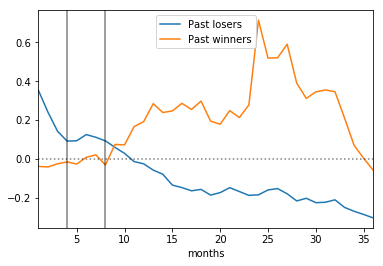

In [61]:
ax = bot_ptf_ret.groupby('months')['exret'].mean().plot(label='Past losers')
top_ptf_ret.groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0, color='black', alpha=0.5, linestyle=':')
ax.axvline(x=4, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=8, color='black', alpha=0.5, linestyle='-')

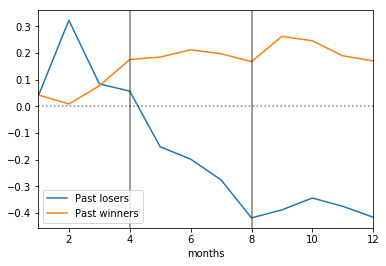

In [62]:
# Only pre 1989
ax = bot_ptf_ret.set_index('date')[:'1989'].groupby('months')['exret'].mean().plot(label='Past losers')
top_ptf_ret.set_index('date')[:'1989'].groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0, color='black', alpha=0.5, linestyle=':')
ax.axvline(x=4, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=8, color='black', alpha=0.5, linestyle='-')

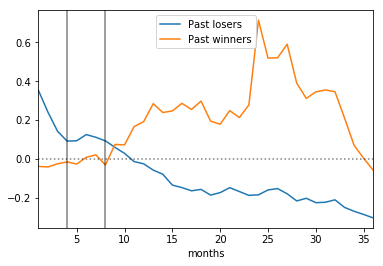

In [63]:
# Only post 1989
ax = bot_ptf_ret.set_index('date')['1989':].groupby('months')['exret'].mean().plot(label='Past losers')
top_ptf_ret.set_index('date')['1989':].groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0, color='black', alpha=0.5, linestyle=':')
ax.axvline(x=4, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=8, color='black', alpha=0.5, linestyle='-')

Exercise: check if the results chnage significantly if portfolio formation is not done in January.